<a href="https://colab.research.google.com/github/Wishbert/Portfolio/blob/main/Keras_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras CNN

#  Keras_CNN

Below is a classification of Malaria Cells. 
The dataset used contains images of the infected cells and unifected cells
The images are of different sizes

In [13]:
!curl -O ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  337M  100  337M    0     0  38.2M      0  0:00:08  0:00:08 --:--:-- 45.6M


In [14]:
!unzip -q cell_images.zip

In [11]:
import os

In [15]:
num_skipped = 0
for folder_name in ("Parasitized", "Uninfected"):
    folder_path = os.path.join("cell_images", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            png_true = 'png' in fname
        finally:
            fobj.close()

        if not png_true:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)



Deleted 2 images


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
image_size = (180, 180) #the images all have the same size 
batch_size = 32

#seeding is fixed to get a 'fixed' random data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cell_images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cell_images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


# Visualizing the data

In [20]:
import matplotlib.pyplot as plt

##### The labeling below shows that 1 is for uninfected Cells 0 is the infected Cells

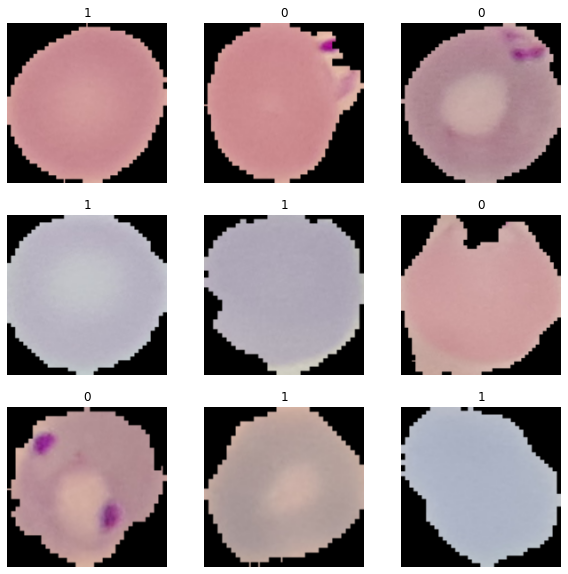

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [22]:
agumentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor = (-0.2,0.3)),
        layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.3),width_factor=(-0.2,0.3)),
    ]
)

Visualising the agumentation


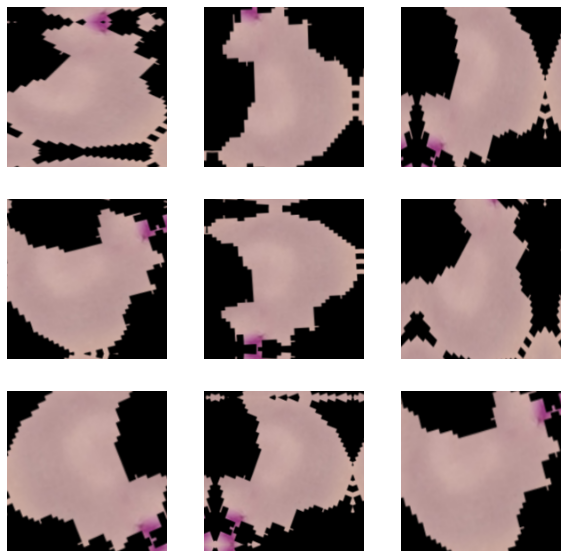

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        agumented_image = agumentation(images)
        plt.imshow(agumented_image[0].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
#Dealing with a big dataset
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Building a Model
Functional model

In [25]:
def model(input_shape):
    
    inputs = keras.Input(shape = input_shape)
    layer_output = agumentation(inputs) #image agumentation
    
    layer_output = layers.experimental.preprocessing.Rescaling(1/255)(layer_output) #taking advantage of the GPU
    layer_output = layers.Conv2D(32,3,padding = "same",strides = 2)(layer_output)
    layer_output = layers.BatchNormalization()(layer_output)
    layer_output = layers.Activation('relu')(layer_output)
    
    layer_output = layers.Conv2D(64,3,padding = "same")(layer_output)
    layer_output = layers.BatchNormalization()(layer_output)
    layer_output = layers.Activation('relu')(layer_output)
    
    previous_layer_output = layer_output
    
    for filter_num in [128, 256, 512, 756]:
        for _ in range(2):
            layer_output = layers.Activation('relu')(layer_output)
            layer_output = layers.SeparableConv2D(filter_num,3,padding = 'same')(layer_output)
            layer_output = layers.BatchNormalization()(layer_output)
        
        layer_output = layers.MaxPooling2D(3,padding = 'same', strides = 2)(layer_output)
        
        residual = layers.Conv2D(filter_num,1,strides = 2, padding = 'same')(previous_layer_output)
        layer_output = layers.add([layer_output,residual])
        previous_layer_output = layer_output
        
    layer_output = layers.SeparableConv2D(1024,3,padding = "same")(layer_output)
    layer_output = layers.BatchNormalization()(layer_output)
    layer_output = layers.Activation('relu')(layer_output)
    
    layer_output = layers.GlobalAveragePooling2D()(layer_output)
    layer_output = layers.Dropout(0.3)(layer_output)
    
    #for training with 2 classes
    activation = 'sigmoid' #the activation is sigmoid because it will output 1 or 0 which is relevant since we are deeling with a binary classification
    units = 1
    outputs = layers.Dense(
                units,
                activation = activation
    )(layer_output)
    
    return keras.Model(inputs,outputs)

# Training the Model

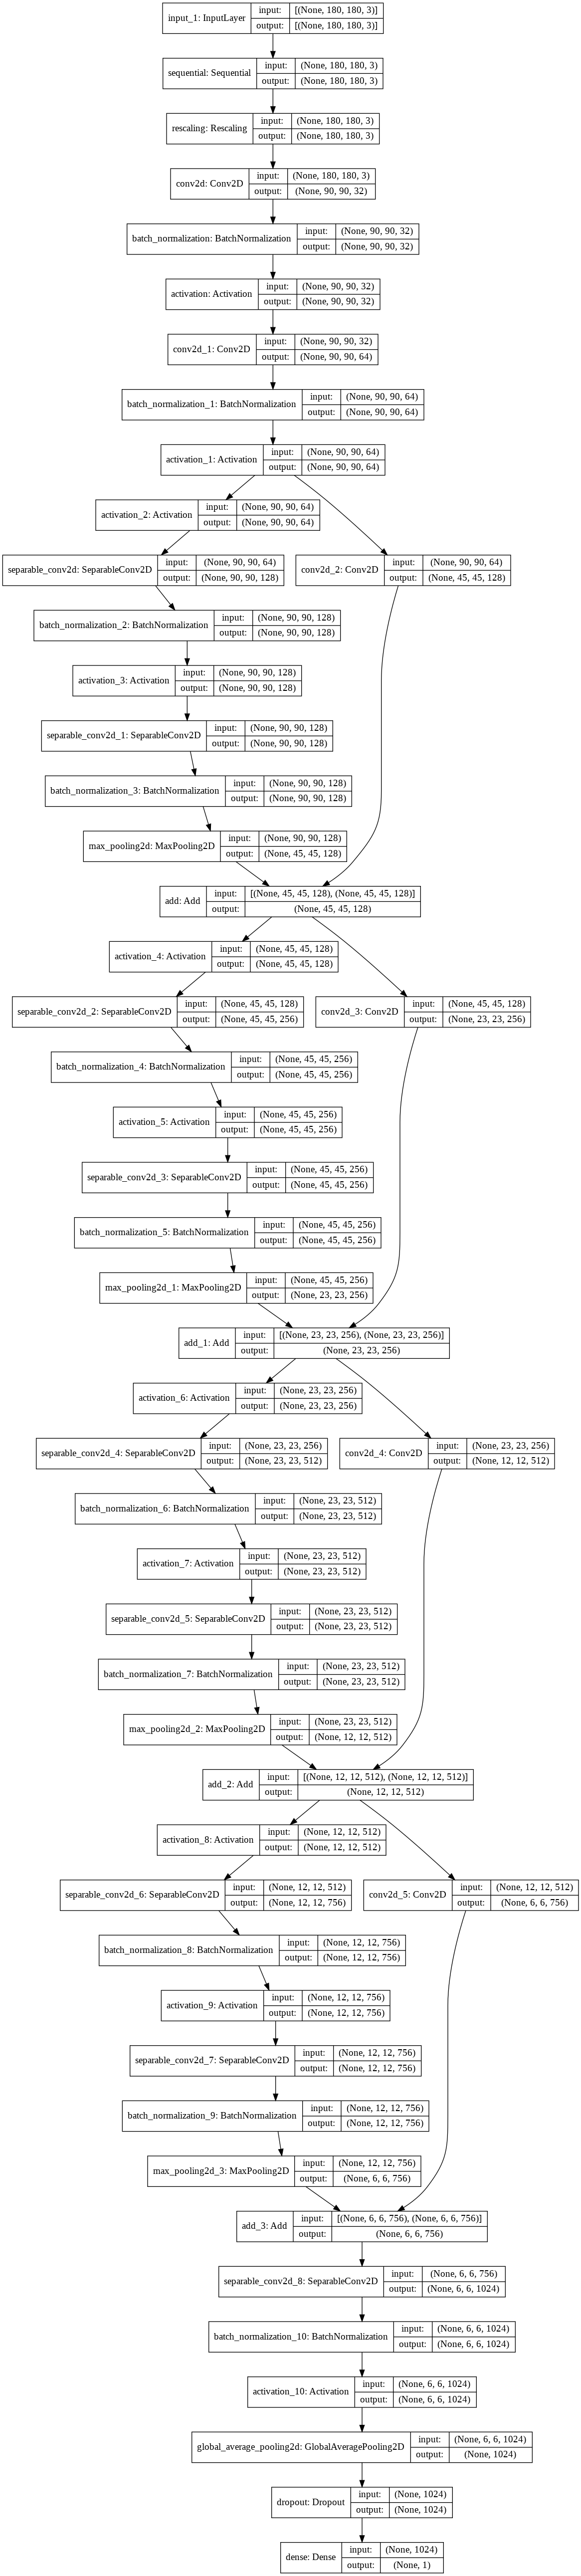

In [26]:
model = model(input_shape=image_size + (3,) # the three is because usually an image 3 channels "RGB"
             )
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
689/689 [==============================] - 216s 264ms/step - loss: 0.2170 - accuracy: 0.9202 - val_loss: 0.2000 - val_accuracy: 0.9465


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
689/689 [==============================] - 181s 263ms/step - loss: 0.1643 - accuracy: 0.9469 - val_loss: 0.1781 - val_accuracy: 0.9398
Epoch 3/50
689/689 [==============================] - 181s 263ms/step - loss: 0.1549 - accuracy: 0.9492 - val_loss: 0.1593 - val_accuracy: 0.9479
Epoch 4/50
689/689 [==============================] - 182s 264ms/step - loss: 0.1455 - accuracy: 0.9519 - val_loss: 0.1519 - val_accuracy: 0.9512
Epoch 5/50
689/689 [==============================] - 182s 263ms/step - loss: 0.1379 - accuracy: 0.9536 - val_loss: 0.1435 - val_accuracy: 0.9528
Epoch 6/50
689/689 [==============================] - 182s 263ms/step - loss: 0.1331 - accuracy: 0.9562 - val_loss: 0.1479 - val_accuracy: 0.9557
Epoch 7/50
689/689 [==============================] - 182s 263ms/step - loss: 0.1316 - accuracy: 0.9558 - val_loss: 0.2056 - val_accuracy: 0.9260
Epoch 8/50
689/689 [==============================] - 181s 263ms/step - loss: 0.1271 - accuracy: 0.9568 - val_loss: 0.2032 -

## Deep learning Vs Machine Learning
Deep learning generally outperforms traditional machine learning in regards to computer vision, because deep learning becomes more accurate when trained with large data and computations in computer vision usually require very large data and thus deep learning outperforms traditional machine learning

## Popular Computer Vison Techniques
  

*   Object detection
*   Image Classification


